In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType,IntegerType

In [3]:
spark = SparkSession.builder.appName("IMDb Ratings Data Processing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/24 14:22:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/24 14:22:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
ratings_schema = StructType([
    StructField("tconst", StringType(), True),
    StructField("averageRating", FloatType(), True),
    StructField("numVotes", IntegerType(), True)
    ])

In [4]:
ratings_df = spark.read.csv("../data/title.ratings.tsv", header=True, schema=ratings_schema, sep="\t")

In [6]:
ratings_df.printSchema()
ratings_df.head(5)

root
 |-- tconst: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



[Row(tconst='tt0000001', averageRating=5.699999809265137, numVotes=2142),
 Row(tconst='tt0000002', averageRating=5.5, numVotes=290),
 Row(tconst='tt0000003', averageRating=6.400000095367432, numVotes=2179),
 Row(tconst='tt0000004', averageRating=5.300000190734863, numVotes=186),
 Row(tconst='tt0000005', averageRating=6.199999809265137, numVotes=2914)]

In [7]:
string_cols = [field.name for field in ratings_df.schema.fields if isinstance(field.dataType, StringType)]
print(f"String columns: {string_cols}")

String columns: ['tconst']


In [8]:
numeric_cols = [field.name for field in ratings_df.schema.fields if isinstance(field.dataType, (FloatType, IntegerType))]
print(f"Numeric columns: {numeric_cols}")

Numeric columns: ['averageRating', 'numVotes']


In [9]:
print("Number of rows:")
ratings_df.count()

Number of rows:


1547472

In [11]:
print("Number of columns:")
len(ratings_df.columns)

Number of columns:


3

In [12]:
ratings_df = ratings_df.replace('\\N', None)

In [13]:
from pyspark.sql.functions import count
duplicates_df = ratings_df.groupBy("tconst").agg(count("*").alias("count")).filter("count > 1")
duplicates_df.show(truncate=False)

+------+-----+
|tconst|count|
+------+-----+
+------+-----+



In [40]:
print("Number of rows:")
ratings_df.count()

Number of rows:


1547472

In [14]:
numeric_summary = ratings_df.describe()
numeric_summary.show()

[Stage 12:========>                                                 (1 + 6) / 7]

+-------+---------+------------------+------------------+
|summary|   tconst|     averageRating|          numVotes|
+-------+---------+------------------+------------------+
|  count|  1547472|           1547472|           1547472|
|   mean|     null| 6.951499225611713|1024.7755280870995|
| stddev|     null|1.3874393822869346|17817.066823722198|
|    min|tt0000001|               1.0|                 5|
|    max|tt9916880|              10.0|           3020192|
+-------+---------+------------------+------------------+



In [24]:
from pyspark.sql.functions import col, sum

null_counts = ratings_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in ratings_df.columns if isinstance(ratings_df.schema[c].dataType, (IntegerType, FloatType))])
null_counts.show()

+-------------+--------+
|averageRating|numVotes|
+-------------+--------+
|            0|       0|
+-------------+--------+



As we can see from the above statistics, there is no duplicates or empty cells in the numeric columns.

In [ ]:
!pip install matplotlib seaborn

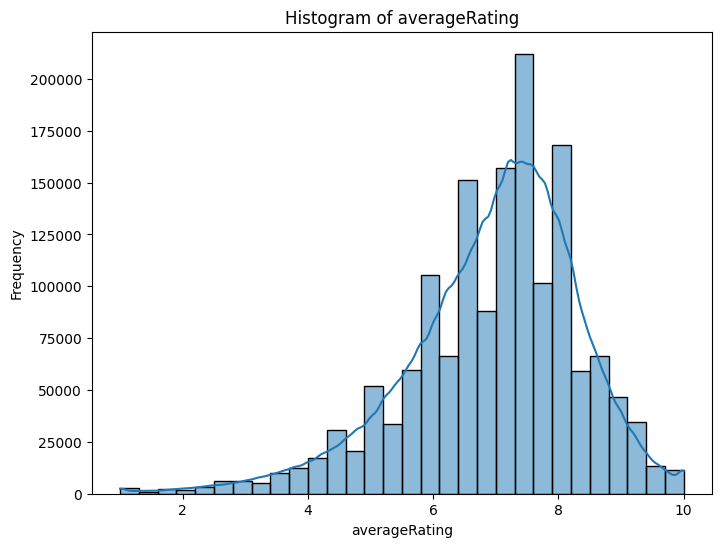

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = [c for c in ratings_df.columns if isinstance(ratings_df.schema[c].dataType, (IntegerType, FloatType))]
ratings_pandas_df = ratings_df.select(numeric_columns).toPandas()

plt.figure(figsize=(8, 6))
sns.histplot(ratings_pandas_df['averageRating'], kde=True, bins=30)
plt.title('Histogram of averageRating')
plt.xlabel('averageRating')
plt.ylabel('Frequency')
plt.show()

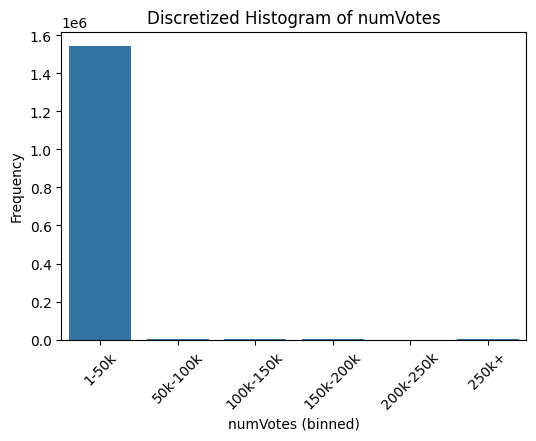

In [35]:
bins = [0, 50000, 100000, 150000, 200000, 250000, float('inf')]
labels = ['1-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k+']

ratings_pandas_df['numVotes_binned'] = pd.cut(ratings_pandas_df['numVotes'], bins=bins, labels=labels)

plt.figure(figsize=(6, 4))
sns.countplot(x='numVotes_binned', data=ratings_pandas_df)
plt.title('Discretized Histogram of numVotes')
plt.xlabel('numVotes (binned)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_22/615109631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)


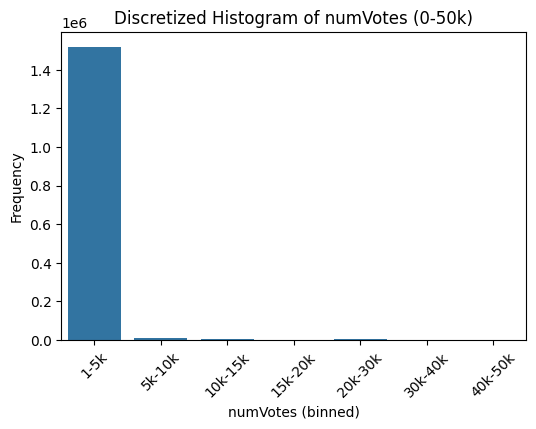

In [36]:
filtered_df = ratings_pandas_df[ratings_pandas_df['numVotes'] <= 50000]

bins = [0, 5000, 10000, 15000, 20000, 30000, 40000, 50000]
labels = ['1-5k', '5k-10k', '10k-15k', '15k-20k', '20k-30k', '30k-40k', '40k-50k']

filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)

plt.figure(figsize=(6, 4))
sns.countplot(x='numVotes_binned', data=filtered_df)
plt.title('Discretized Histogram of numVotes (0-50k)')
plt.xlabel('numVotes (binned)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_22/3078766064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)


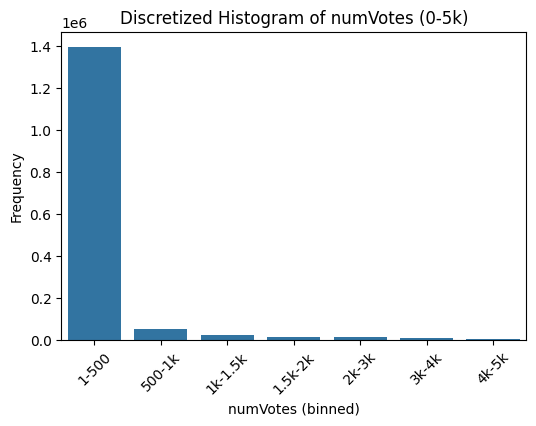

In [37]:
filtered_df = ratings_pandas_df[ratings_pandas_df['numVotes'] <= 5000]

bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000]
labels = ['1-500', '500-1k', '1k-1.5k', '1.5k-2k', '2k-3k', '3k-4k', '4k-5k']

filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)

plt.figure(figsize=(6, 4))
sns.countplot(x='numVotes_binned', data=filtered_df)
plt.title('Discretized Histogram of numVotes (0-5k)')
plt.xlabel('numVotes (binned)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_22/2253165127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)


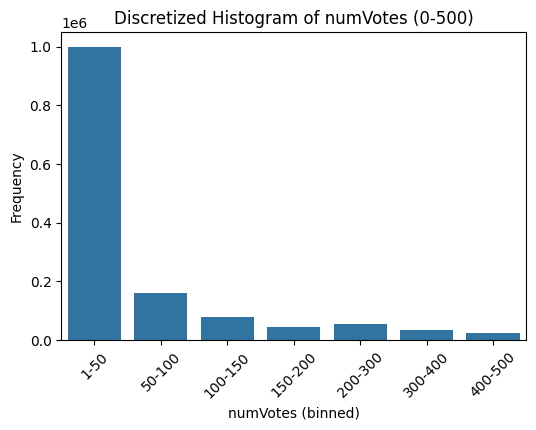

In [38]:
filtered_df = ratings_pandas_df[ratings_pandas_df['numVotes'] <= 500]

bins = [0, 50, 100, 150, 200, 300, 400, 500]
labels = ['1-50', '50-100', '100-150', '150-200', '200-300', '300-400', '400-500']

filtered_df['numVotes_binned'] = pd.cut(filtered_df['numVotes'], bins=bins, labels=labels)

plt.figure(figsize=(6, 4))
sns.countplot(x='numVotes_binned', data=filtered_df)
plt.title('Discretized Histogram of numVotes (0-500)')
plt.xlabel('numVotes (binned)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [5]:
ratings_df = spark.read.csv("../data/title.ratings.tsv", header=True, schema=ratings_schema, sep="\t")
ratings_df = ratings_df.replace('\\N', None)

In [9]:
output_dir = '../data/title.ratings.cleaned.tsv'
ratings_df.coalesce(1).write.option("header", True).option("sep", "\t").mode("overwrite").csv(output_dir)

print(f"Data saved as {output_dir}")

Data saved as ../data/title.ratings.cleaned.tsv
